In [24]:
# from src.hrv_epatch.io.tdms import extract_tdms_channel
from src.hrv_epatch.io.data_loader import Load_full_ecg_data

from __future__ import annotations

import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

from scipy.signal import welch
from scipy import stats
from datetime import timedelta, datetime as dt

from src.hrv_epatch.io.data_loader import Load_full_ecg_data


@dataclass
class SeizureEvent:
    seizure_id: int
    t0: float       # sekunder fra recording start
    t1: float       # sekunder fra recording start


In [25]:
data = Load_full_ecg_data("Patient 5")
patient_id = data["PatientID"]
ecg_df = data["ECG"]
seizure_df = data["Seizures"]
sample_rate = data["SampleRate"]


print(f"Loaded data for {patient_id}:")
print(f"- ECG signal shape: {ecg_df.shape}")
print(f"- Number of seizures: {seizure_df.shape[0]}")
print(f"- Sample rate: {sample_rate} Hz")

print(seizure_df.head())

start_ts = pd.to_datetime(data["StartTime"])
print("Recording start:", start_ts)

# Alternative
# start_ts = pd.to_datetime(ecg_df["Timestamp"].iloc[0])


Loaded data for Patient 5:
- ECG signal shape: (82460288, 2)
- Number of seizures: 3
- Sample rate: 512.0 Hz
0  NaN Anfald nr.      Dato Anfaldsstart Klinisk (tt:mm:ss)  \
0  NaN          1  13.10.16                        07:26:57   
1  NaN          2  13.10.16                        14:47:50   
2  NaN          3  13.10.16                        15:36:28   

0 Anfaldsstart EEG (tt:mm:ss) Anfaldstop Klinisk (tt:mm:ss)  \
0                    07:26:31                      07:28:57   
1                    14:47:29                      14:49:23   
2                    15:36:30                      15:38:38   

0 Anfaldstop EEG (tt:mm:ss)       Anfaldstype Evt. bemærkninger  
0                  07:26:58  kompleks partiel               NaN  
1                  14:49:24  kompleks partiel               NaN  
2                  15:38:38  kompleks partiel               NaN  
Recording start: 2016-10-12 11:05:02


In [26]:
seizure_events: List[SeizureEvent] = []

for _, row in seizure_df.iterrows():
    # Byg fulde datetime-stempler fra 'Dato' + tidstekst
    date_str = str(row["Dato"]).strip() if pd.notna(row["Dato"]) else None

    def parse_dt(time_str_col: str) -> Optional[pd.Timestamp]:
        if date_str is None or pd.isna(row[time_str_col]):
            return None
        timestr = str(row[time_str_col]).strip()
        # Tilpas format hvis nødvendigt (her antaget: dd.mm.yy HH:MM:SS)
        return pd.to_datetime(f"{date_str} {timestr}", format="%d.%m.%y %H:%M:%S", errors="coerce")

    start_klinisk = parse_dt("Anfaldsstart Klinisk (tt:mm:ss)")
    stop_klinisk  = parse_dt("Anfaldstop Klinisk (tt:mm:ss)")
    start_eeg     = parse_dt("Anfaldsstart EEG (tt:mm:ss)")
    stop_eeg      = parse_dt("Anfaldstop EEG (tt:mm:ss)")

    if start_klinisk is not None and stop_klinisk is not None:
        klinisk_duration = (stop_klinisk - start_klinisk).total_seconds()
    else:
        klinisk_duration = 0.0

    if start_eeg is not None and stop_eeg is not None:
        eeg_duration = (stop_eeg - start_eeg).total_seconds()
    else:
        eeg_duration = 0.0

    # Vælg hvilken annotation vi tror mest på (klinisk vs EEG)
    if klinisk_duration >= eeg_duration and start_klinisk is not None:
        t0_dt = start_klinisk
        duration = klinisk_duration
    elif start_eeg is not None:
        t0_dt = start_eeg
        duration = eeg_duration
    else:
        continue  # ingen valid annotation

    # Konverter til sekunder fra recording start
    t0 = (t0_dt - start_ts).total_seconds()
    t1 = t0 + duration

    if t1 <= t0:
        continue  # discard hvis duration er 0 eller negativ

    ev = SeizureEvent(
        seizure_id=int(row["Anfald nr."]),
        t0=t0,
        t1=t1,
    )
    seizure_events.append(ev)

print("Antal validerede seizure events:", len(seizure_events))
if seizure_events:
    print("Eksempler:", seizure_events[:3])


Antal validerede seizure events: 3
Eksempler: [SeizureEvent(seizure_id=1, t0=73315.0, t1=73435.0), SeizureEvent(seizure_id=2, t0=99747.0, t1=99862.0), SeizureEvent(seizure_id=3, t0=102686.0, t1=102816.0)]


In [28]:
# %%
# Ekstraher 1D-ECG-signal og optagelseslængde i sekunder
# Antag at ecg_df har en kolonne med selve signalværdien:
if "Value" in ecg_df.columns:
    ecg_signal = ecg_df["Value"].to_numpy(dtype=float)
elif "ECG" in ecg_df.columns:
    ecg_signal = ecg_df["ECG"].to_numpy(dtype=float)
else:
    # fallback: vælg første numeriske kolonne
    num_cols = ecg_df.select_dtypes(include=[np.number]).columns
    if len(num_cols) == 0:
        raise ValueError("Kunne ikke finde numeriske ECG-kolonner i ecg_df")
    ecg_signal = ecg_df[num_cols[0]].to_numpy(dtype=float)

fs = float(sample_rate)
rec_duration_s = len(ecg_signal) / fs
print(f"Recording duration: {rec_duration_s/3600:.2f} timer")


Recording duration: 44.74 timer


In [29]:
# %%
def extract_segment(
    x: np.ndarray,
    fs: float,
    t0: float,
    t1: float,
) -> np.ndarray:
    """Udtræk ECG-segment mellem t0–t1 sekunder (relativt til recording start)."""
    i0 = int(round(t0 * fs))
    i1 = int(round(t1 * fs))
    i0 = max(i0, 0)
    i1 = min(i1, len(x))
    return x[i0:i1]


In [31]:
def compute_psd_features(
    x_seg: np.ndarray,
    fs: float,
    bands: Optional[Dict[str, Tuple[float, float]]] = None,
) -> Dict[str, float]:
    """
    Beregn simple spektre-features på et 1D ECG-segment (Welch).
    Returnerer total power + bånd-power + relativ bånd-power.
    """
    if bands is None:
        bands = {
            "band_0_5_5": (0.5, 5.0),
            "band_5_15": (5.0, 15.0),
            "band_15_40": (15.0, 40.0),
        }

    if len(x_seg) < 2 * fs:  # for kort segment
        base = {"total_power": np.nan}
        for name in bands:
            base[f"{name}_power"] = np.nan
            base[f"{name}_rel_power"] = np.nan
        return base

    nperseg = min(4 * int(fs), len(x_seg))
    f, Pxx = welch(x_seg, fs=fs, nperseg=nperseg)

    features: Dict[str, float] = {}
    total_power = np.trapz(Pxx, f)
    features["total_power"] = total_power

    for name, (f_lo, f_hi) in bands.items():
        mask = (f >= f_lo) & (f <= f_hi)
        if not np.any(mask):
            band_power = np.nan
        else:
            band_power = np.trapz(Pxx[mask], f[mask])
        features[f"{name}_power"] = band_power
        features[f"{name}_rel_power"] = (
            band_power / total_power if total_power > 0 else np.nan
        )

    return features

def csi_modcsi(rr: np.ndarray) -> Tuple[float, float]:
    """
    Beregn CSI og ModCSI ud fra RR-intervaller (sekunder)
    via Poincaré SD1 og SD2 (Jeppesen-definition).
    """
    if len(rr) < 4:
        return np.nan, np.nan

    diff = np.diff(rr)
    summ = rr[:-1] + rr[1:]

    sd1 = np.std((np.sqrt(2) / 2.0) * diff, ddof=1)
    sd2 = np.std((np.sqrt(2) / 2.0) * summ, ddof=1)

    T = 4 * sd1
    L = 4 * sd2

    if T == 0:
        return np.nan, np.nan

    csi = L / T
    modcsi = (L ** 2) / T
    return csi, modcsi

def tachogram_slope(rr: np.ndarray, times: Optional[np.ndarray] = None) -> float:
    """
    Beregn lineær slope af tachogram (RR vs tid eller indeks).
    """
    if len(rr) < 4:
        return np.nan

    if times is None:
        x = np.arange(len(rr))
    else:
        x = np.asarray(times)
        if x.shape != rr.shape:
            raise ValueError("times og rr skal have samme længde")

    slope, _, _, _, _ = stats.linregress(x, rr)
    return slope

def compute_hrv_features(
    rr_times: Optional[np.ndarray],
    rr_intervals: Optional[np.ndarray],
    t0: float,
    t1: float,
) -> Dict[str, float]:
    """
    Beregn HRV/CSI/ModCSI/slope-features for RR-intervaler indenfor [t0, t1].

    Hvis rr_times eller rr_intervals er None, returneres NaN for alle HRV-features,
    så scriptet stadig kan køre uden at HRV-delen er koblet på endnu.
    """
    if rr_times is None or rr_intervals is None:
        return {
            "rr_mean": np.nan,
            "rr_std": np.nan,
            "hr_mean": np.nan,
            "hr_std": np.nan,
            "csi": np.nan,
            "modcsi": np.nan,
            "slope": np.nan,
            "modcsi_x_slope": np.nan,
        }

    rr_times = np.asarray(rr_times)
    rr_intervals = np.asarray(rr_intervals)

    mask = (rr_times >= t0) & (rr_times <= t1)
    rr_win = rr_intervals[mask]
    t_win = rr_times[mask]

    if rr_win.size < 10:
        return {
            "rr_mean": np.nan,
            "rr_std": np.nan,
            "hr_mean": np.nan,
            "hr_std": np.nan,
            "csi": np.nan,
            "modcsi": np.nan,
            "slope": np.nan,
            "modcsi_x_slope": np.nan,
        }

    rr_mean = float(np.mean(rr_win))
    rr_std = float(np.std(rr_win, ddof=1))
    hr = 60.0 / rr_win
    hr_mean = float(np.mean(hr))
    hr_std = float(np.std(hr, ddof=1))

    csi, modcsi = csi_modcsi(rr_win)
    slope = tachogram_slope(rr_win, t_win)

    return {
        "rr_mean": rr_mean,
        "rr_std": rr_std,
        "hr_mean": hr_mean,
        "hr_std": hr_std,
        "csi": csi,
        "modcsi": modcsi,
        "slope": slope,
        "modcsi_x_slope": (
            modcsi * slope if np.isfinite(modcsi) and np.isfinite(slope) else np.nan
        ),
    }


In [32]:
# %%
def build_feature_table_for_patient(
    patient_id: str,
    ecg_signal: np.ndarray,
    fs: float,
    seizure_events: List[SeizureEvent],
    rr_times: Optional[np.ndarray] = None,
    rr_intervals: Optional[np.ndarray] = None,
    baseline_offset: float = 3600.0,  # fx 1 time efter seizure-start
) -> pd.DataFrame:
    """
    Byg en feature-tabel (seizure + baseline) for en patient.

    - Bruger dine SeizureEvent (t0, t1 i sek fra recording start)
    - Ekstraherer ECG-segmenter for seizure + baseline
    - Beregner frekvens-features (PSD) + HRV-features (hvis RR angives)
    """
    rows = []
    rec_duration_s = len(ecg_signal) / fs

    for ev in seizure_events:
        dur = ev.t1 - ev.t0

        # --- Seizure-segment ---
        x_seiz = extract_segment(ecg_signal, fs, ev.t0, ev.t1)
        psd_seiz = compute_psd_features(x_seiz, fs)
        hrv_seiz = compute_hrv_features(rr_times, rr_intervals, ev.t0, ev.t1)

        row_seiz = {
            "patient_id": patient_id,
            "seizure_id": ev.seizure_id,
            "segment_type": "seizure",
            "t0": ev.t0,
            "t1": ev.t1,
            "duration_s": dur,
        }
        row_seiz.update(psd_seiz)
        row_seiz.update(hrv_seiz)
        rows.append(row_seiz)

        # --- Baseline-segment (samme længde, forskudt i tid) ---
        base_t0 = ev.t0 + baseline_offset
        base_t1 = base_t0 + dur

        if base_t1 <= rec_duration_s:
            x_base = extract_segment(ecg_signal, fs, base_t0, base_t1)
            psd_base = compute_psd_features(x_base, fs)
            hrv_base = compute_hrv_features(rr_times, rr_intervals, base_t0, base_t1)

            row_base = {
                "patient_id": patient_id,
                "seizure_id": ev.seizure_id,
                "segment_type": "baseline",
                "t0": base_t0,
                "t1": base_t1,
                "duration_s": dur,
            }
            row_base.update(psd_base)
            row_base.update(hrv_base)
            rows.append(row_base)

    return pd.DataFrame(rows)


In [35]:
# %%
# TODO: hvis du har RR-data i 'data', kan du koble dem på her.
# Eksempel (tilpas kolonnenavne til din faktiske struktur):
rr_times = None
rr_intervals = None

# Hvis du har noget ala:
# rr_df = data["RR"]
# rr_times = rr_df["Time_s"].to_numpy()
# rr_intervals = rr_df["RR_s"].to_numpy()

df_features = build_feature_table_for_patient(
    patient_id=patient_id,
    ecg_signal=ecg_signal,
    fs=fs,
    seizure_events=seizure_events,
    rr_times=rr_times,
    rr_intervals=rr_intervals,
    baseline_offset=-1200.0,
)

print(df_features.head())
print(df_features.segment_type.value_counts())


  patient_id  seizure_id segment_type        t0        t1  duration_s  \
0  Patient 5           1      seizure   73315.0   73435.0       120.0   
1  Patient 5           1     baseline   72115.0   72235.0       120.0   
2  Patient 5           2      seizure   99747.0   99862.0       115.0   
3  Patient 5           2     baseline   98547.0   98662.0       115.0   
4  Patient 5           3      seizure  102686.0  102816.0       130.0   

     total_power  band_0_5_5_power  band_0_5_5_rel_power  band_5_15_power  \
0  178516.704293      53407.846031              0.299176     64360.247342   
1   45842.912442      17735.071975              0.386866     19387.573790   
2  441276.060907     117094.331586              0.265354     98579.661939   
3   74041.469764      24128.016092              0.325872     32534.452736   
4  946780.851518     406912.467162              0.429785     66747.063164   

   ...  band_15_40_power  band_15_40_rel_power  rr_mean  rr_std  hr_mean  \
0  ...      21761.0209

C:\Users\kvjkv\AppData\Local\Temp\ipykernel_2904\2034574735.py:28: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = np.trapz(Pxx, f)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_2904\2034574735.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(Pxx[mask], f[mask])


In [36]:
# %%
out_path = f"./_analysis/{patient_id}_seizure_baseline_features.csv"
import os
os.makedirs(os.path.dirname(out_path), exist_ok=True)
df_features.to_csv(out_path, index=False)
print("Saved feature table to:", out_path)


Saved feature table to: ./_analysis/Patient 5_seizure_baseline_features.csv


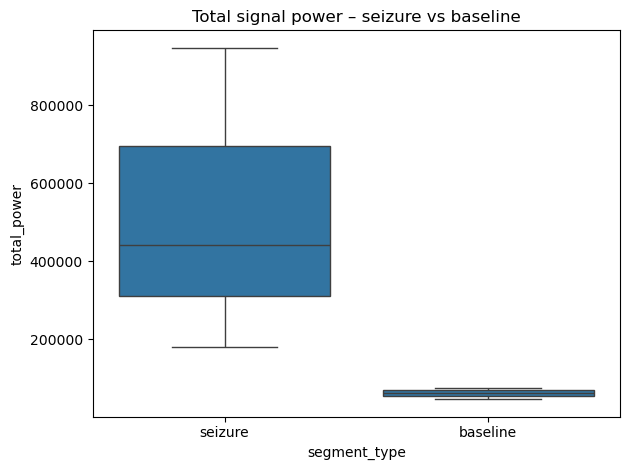

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(data=df_features, x="segment_type", y="total_power")
plt.title("Total signal power – seizure vs baseline")
plt.tight_layout()
plt.show()


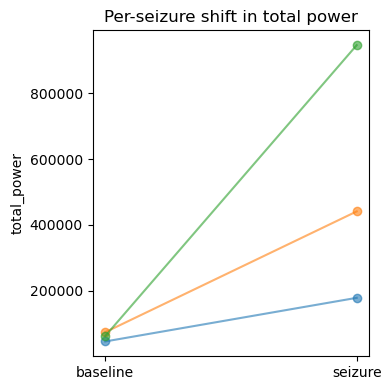

In [41]:
df_wide = df_features.pivot_table(
    index="seizure_id",
    columns="segment_type",
    values="total_power"
).reset_index()

plt.figure(figsize=(4,4))
for _, r in df_wide.iterrows():
    plt.plot(["baseline", "seizure"], [r["baseline"], r["seizure"]], "-o", alpha=0.6)
plt.title("Per-seizure shift in total power")
plt.ylabel("total_power")
plt.tight_layout()
plt.show()


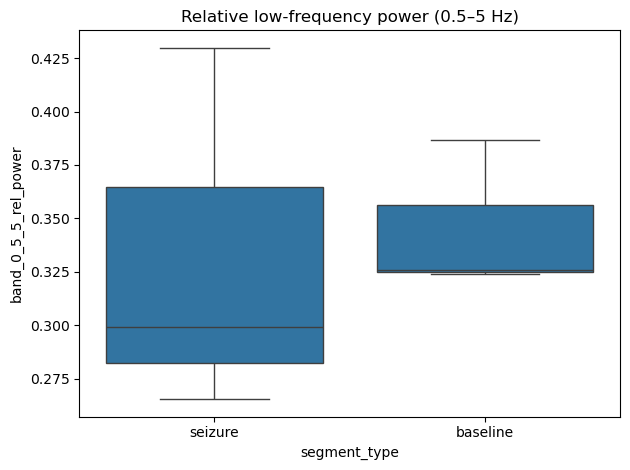

In [42]:
sns.boxplot(
    data=df_features,
    x="segment_type",
    y="band_0_5_5_rel_power"
)
plt.title("Relative low-frequency power (0.5–5 Hz)")
plt.tight_layout()
plt.show()


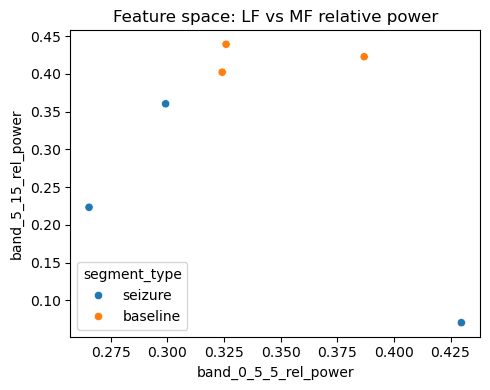

In [43]:
plt.figure(figsize=(5,4))
sns.scatterplot(
    data=df_features,
    x="band_0_5_5_rel_power",
    y="band_5_15_rel_power",
    hue="segment_type"
)
plt.title("Feature space: LF vs MF relative power")
plt.tight_layout()
plt.show()
